# Evaluating the Performance of MiDaS on Drone Data
---

# 1. Gather Data

Here you can configure the script to work with your data.

In [20]:
import os
import rosbag
import matplotlib.pyplot as plt
import numpy as np
import run
import pickle
import eval_utils as eval_utils

bag_file_name = 'test3.bag'         # name of bag file inside folder "drone_data"
data_filename = 'data.pickle'


topic_cam1 = '/d455/infra1/image_rect_raw'
topic_cam2 = '/d455/infra2/image_rect_raw'
topic_camdepth = '/d455/depth/image_rect_raw'

cam1rgb_key = 'cam1'
cam2rgb_key = 'cam2'
cam1depthestimate_key = 'depth_estimate1'
camdepth_key = 'depth_rs'

# running MiDaS
input_path = 'input'
output_path = 'output'


# model_path = 'weights/dpt_large_384.pt'
# model_type = 'dpt_large_384'
model_path = 'weights/midas_v21_small_256.pt'
model_type = 'midas_v21_small_256'


'''------------------------------------------
        Parameters for MiDaS
------------------------------------------'''
optimize=False
side=False
height=None
square=False
grayscale=True # Realsense output is grayscale


# get the current test_run
test_run = eval_utils.check_bag_file(bag_file_name)

In this run of the script we are investigating bag-file 'test3'.
In case the analysis has already been performed and data has been saved, the saved data will be used to save computational time.


In [21]:
# # DELETE STUFF FROM DATA
# data[test_run][model_type][cam1depthestimate_key] = []
# eval_utils.save_data(data_filename, data)

In [22]:
# get timestamps
bag = rosbag.Bag(os.path.join('drone_data', bag_file_name))

timestamps_cam1     = []
timestamps_cam2     = []
timestamps_camdepth = []

for msg in bag.read_messages(topics=[topic_cam1]):
    timestamps_cam1.append(msg.timestamp.to_sec())

for msg in bag.read_messages(topics=[topic_cam2]):
    timestamps_cam2.append(msg.timestamp.to_sec())

for msg in bag.read_messages(topics=[topic_camdepth]):
    timestamps_camdepth.append(msg.timestamp.to_sec())

## 1.1 Gathering Drone Footage

In [23]:
# get image data from rosbag
image_data_infra1_np, image_data_infra2_np, height, width = eval_utils.get_image_data(bag_file_name,topic_cam1,topic_cam2)

# add data to pickle if not done already
eval_utils.update_data(cam1rgb_key, data_filename, test_run, model_type, image_data_infra1_np)
eval_utils.update_data(cam2rgb_key, data_filename, test_run, model_type, image_data_infra2_np)

The bags contain 843 and 840 frames for the given topics.
'data' saved.
'data' saved.


### Examples

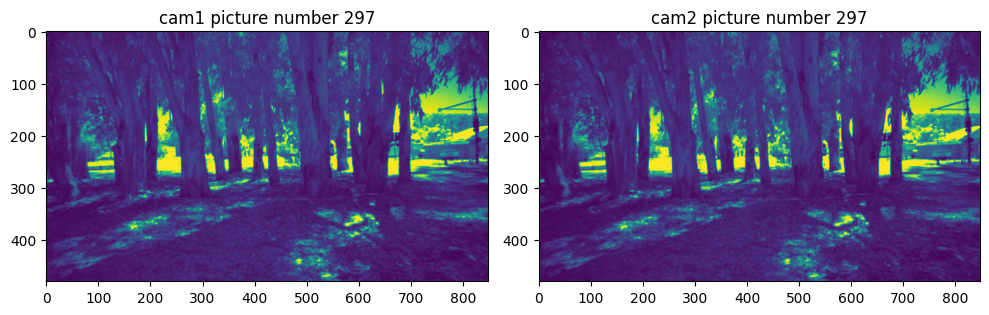

In [24]:
frame1 = 297
frame2 = 297
eval_utils.create_parallel_plots(frame1, frame2, cam1rgb_key, cam2rgb_key, data_filename, test_run, model_type)

## 1.2 Estimating Depth in Drone Footage

In [25]:
# run MiDaS on data from rosbag
run.run(data_filename, test_run, cam1rgb_key, output_path, model_path, model_type, optimize, side, height, square, grayscale)

# Load pickle file
data = eval_utils.load_pickle(data_filename)

Initialize
Device: cpu
Loading weights:  weights/midas_v21_small_256.pt


Using cache found in C:\Users\User/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


Model loaded, number of parameters = 21M
'data' loaded.
Start processing
Finished


### Examples

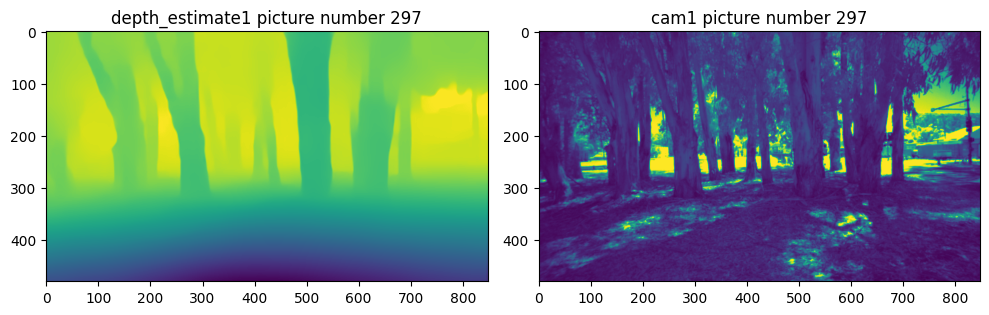

In [26]:
eval_utils.create_parallel_plots(frame1, frame2, 'depth_estimate1', cam1rgb_key, data_filename, test_run, model_type)

## 1.3 Getting "Real" Depth from Intel RealSense

In [27]:
depth_measurement_images = eval_utils.get_depth_data(bag_file_name,topic_camdepth)
# depth_measurement_images = eval_utils.post_process_depth_data(depth_measurement_images)

# add data to pickle if not done already
eval_utils.update_data(camdepth_key, data_filename, test_run, model_type, depth_measurement_images)

'data' saved.


### Examples

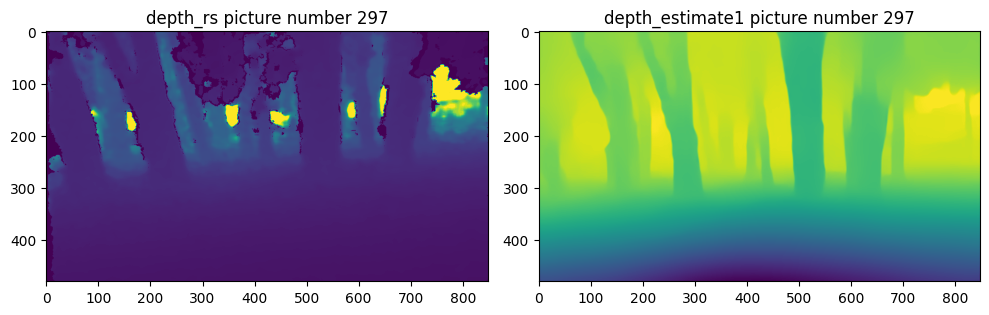

In [28]:
eval_utils.create_parallel_plots(297, 297, camdepth_key,'depth_estimate1', data_filename, test_run, model_type)

Keep in mind that the SAME index of the pictures does not necessarily indicate a correlation with the TIME they were taken.

In the following steps a method will be used to match the "most similar" images. 

---
# 2. Results

In [29]:
# Load pickle file
data = eval_utils.load_pickle(data_filename)

## 2.1 Image Differencing & Image Subtraction

* Image Differencing: two images must first be aligned so that corresponding points coincide
* Image Subtraction: digital numeric value of one pixel or whole image is subtracted from another image

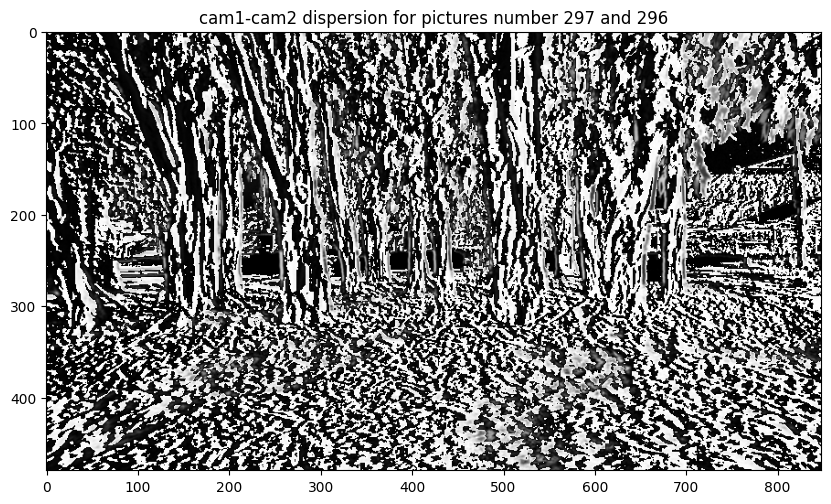

In [30]:
frame1= 297
# get the "most similar image" to a given image by comparing the timestamps of the individual images 
frame2= eval_utils.get_closest_index(frame1, timestamps_cam1, timestamps_cam2)

eval_utils.create_differencing_plot(frame1, frame2, data, cam1rgb_key, cam2rgb_key, test_run, model_type)

## 2.2 Finding Maxima and Minima

### Visualizing Location of Extrema: Depth Measurement

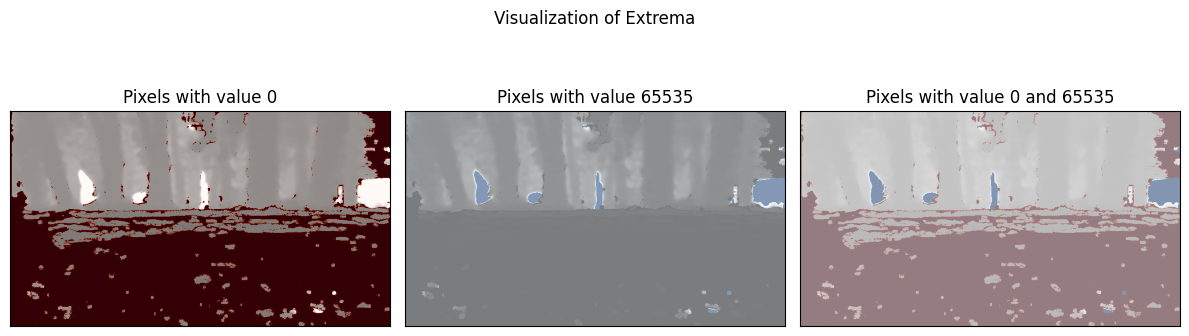

In [31]:
frame1_example = 100
frame_idx = eval_utils.get_closest_index(frame1_example, timestamps_cam1, timestamps_camdepth)
image = data[test_run][model_type][camdepth_key][frame_idx]

eval_utils.plot_extreme_pixels(image)

# num_clusters = 50  # Number of clusters
# circle_scaling_factor = 10  # Scaling the circles around the maxima for better visualization
# eval_utils.plot_clustered_maxima(image, num_clusters, circle_scaling_factor)

> ### Findings: 
>
> * provided with many pixels without any depth information (distance=0)
>   * fails especially detecting the distance of the floor
>   * encounters problems detecting depth on edges (can't be avoided when doing stereo depth estimation)
> * assuming random errors all over the image (detecting large distances in the foreground)
>   
>   --> There is some significant errors in the depth images provided by the Intel RealSense

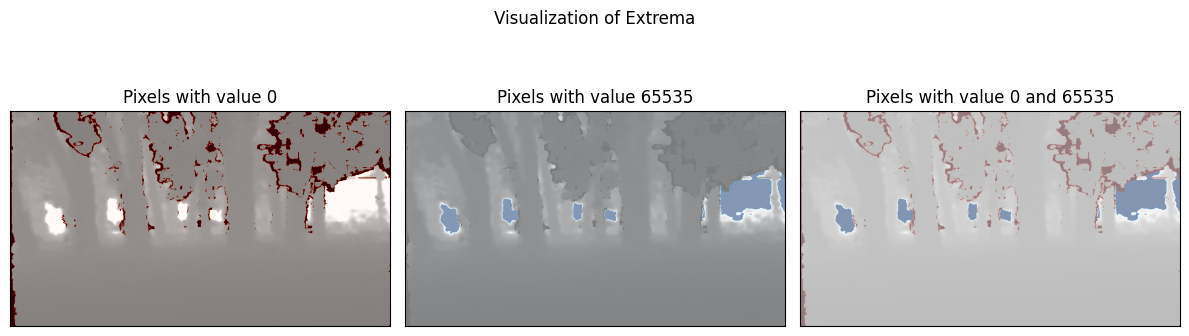

In [32]:
frame1_example = 297
frame_idx = eval_utils.get_closest_index(frame1_example, timestamps_cam1, timestamps_camdepth)
image = data[test_run][model_type][camdepth_key][frame_idx]

eval_utils.plot_extreme_pixels(image)

### Visualizing Location of Extrema: Depth Estimation

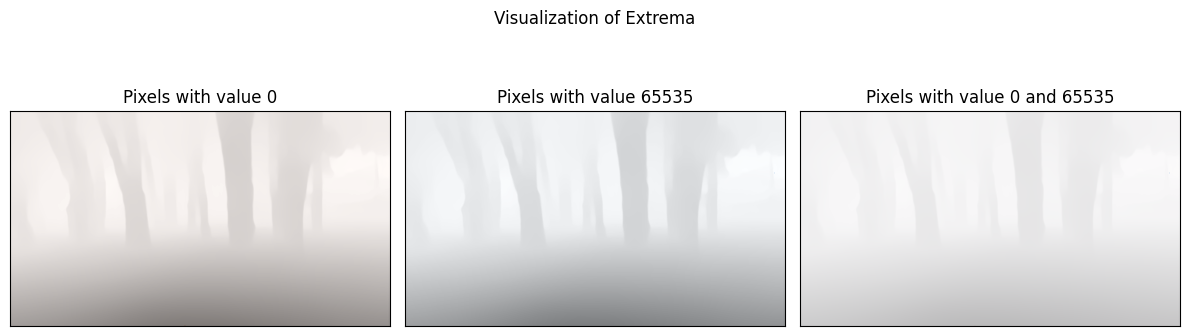

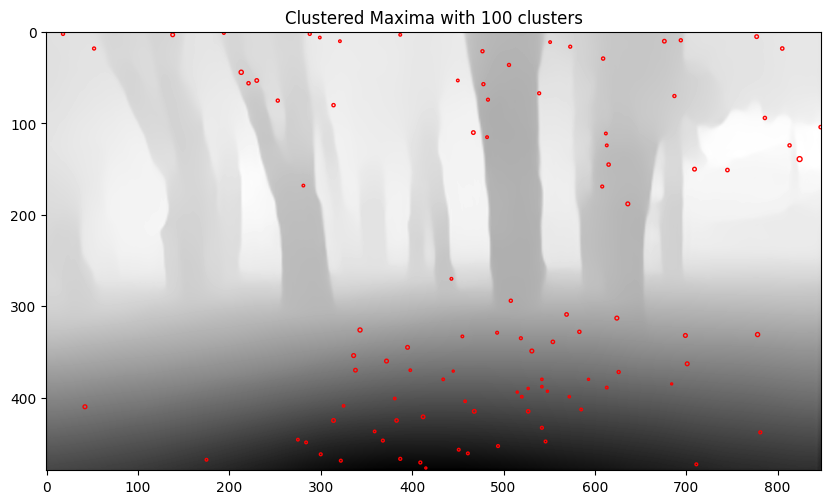

In [33]:
frame_idx = frame_idx # in the caase of depth estimation being done on the information from cam1 
image = data[test_run][model_type][cam1depthestimate_key][frame_idx]

eval_utils.plot_extreme_pixels(image)

num_clusters = 100  # Number of clusters
circle_scaling_factor = 5  # Scaling the circles around the maxima for better visualization
eval_utils.plot_clustered_maxima(image, num_clusters, circle_scaling_factor)

In [34]:
def count_max_occurrences(arr):
    max_value = np.max(arr)  # Find the maximum value in the array
    count = np.count_nonzero(arr == max_value)  # Count the occurrences of the maximum value
    return count

appearances = {}

for image in data[test_run][model_type][cam1depthestimate_key]:
    max_count = count_max_occurrences(image)
    if max_count in appearances:
        appearances[max_count] += 1
    else:
        appearances[max_count] = 1

print(appearances)

{1: 762, 2: 53, 3: 14, 4: 7, 9: 1, 5: 3, 6: 1, 7: 2}


### DEPTH-MEASURMENT: Find images where max. depth is not 65535

The frames of the depth measurement that are not containing a single pixel with the value 65535:
[[  652 49873]
 [  653 56379]]


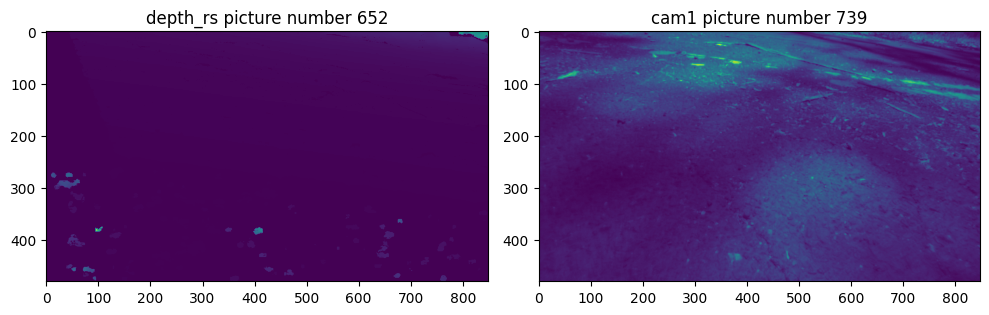

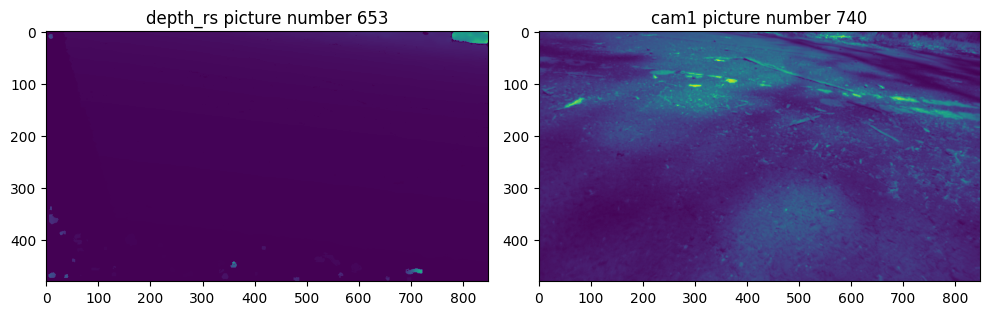

In [35]:
max_depth_measured = eval_utils.get_max_depth_in_frames(data, test_run, model_type, camdepth_key)

indices_not_max_depth_measured = eval_utils.get_indices_images_not_max_depth([max(max_depth_measured)], max_depth_measured)
print('The frames of the depth measurement that are not containing a single pixel with the value 65535:') 
print(indices_not_max_depth_measured)

if indices_not_max_depth_measured.size > 0:
    for i in indices_not_max_depth_measured[:,0]:
        closest_rgb_frame_to_given_depth = eval_utils.get_closest_index(i, timestamps_camdepth, timestamps_cam1)
        eval_utils.create_parallel_plots(i, closest_rgb_frame_to_given_depth, camdepth_key, cam1rgb_key, data_filename, test_run, model_type)

### DEPTH-ESTIMATION: Find images where max. depth is not 65535

In [36]:
max_depth_estimated = eval_utils.get_max_depth_in_frames(data, test_run, model_type, cam1depthestimate_key)

indices_not_max_depth_estimated = eval_utils.get_indices_images_not_max_depth([max(max_depth_estimated)], max_depth_estimated)

print('The frames of the depth measurement that are not containing a single pixel with the value 65535:') 
print(indices_not_max_depth_estimated)

if indices_not_max_depth_estimated.size > 0:
    for i in indices_not_max_depth_estimated[:,0]:
        eval_utils.create_parallel_plots(i, i, cam1depthestimate_key, cam1rgb_key, data_filename, test_run, model_type)

The frames of the depth measurement that are not containing a single pixel with the value 65535:
[]


## 2.3 Comparing Depth-Estimation to "Ground Truth" from RealSense

 1. Finding values that are unreasonable and remove them from the dataset (zeros distance)
 2. Calculate difference from Estimation & Measurement
 3. Visualize magnitude of error
    * Visualize n largest errors with increasing n

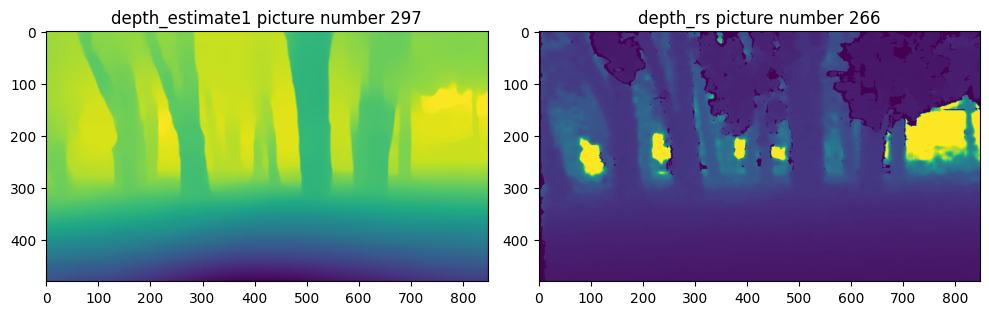

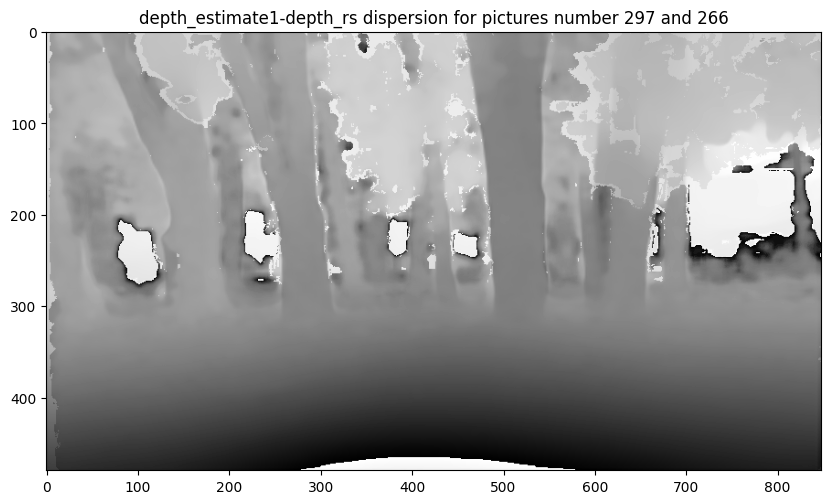

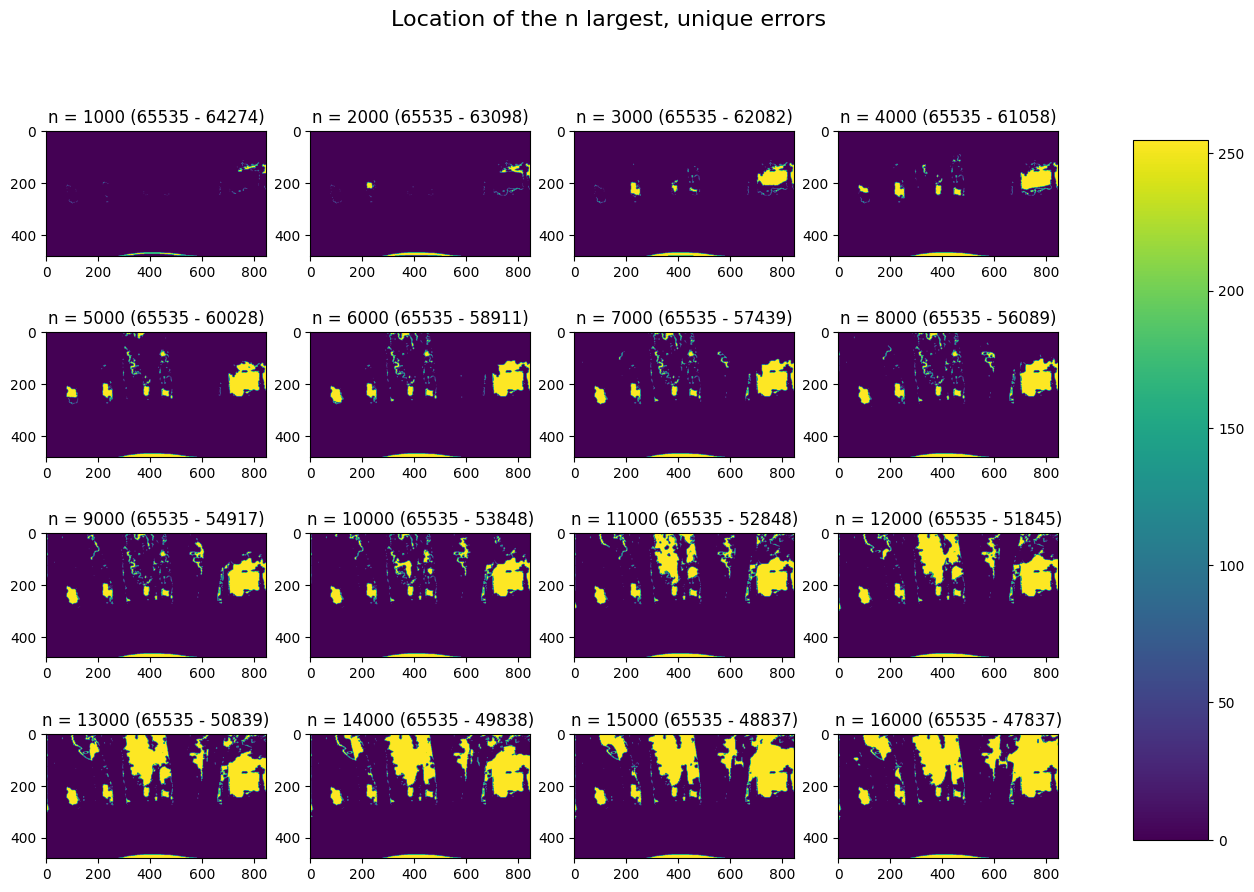

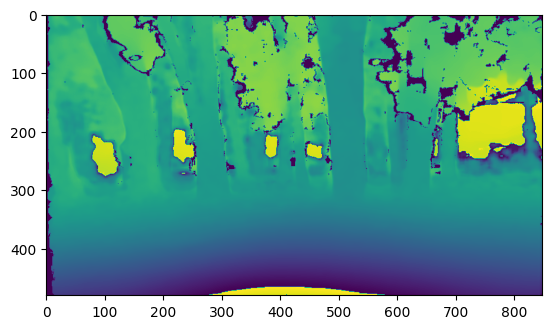

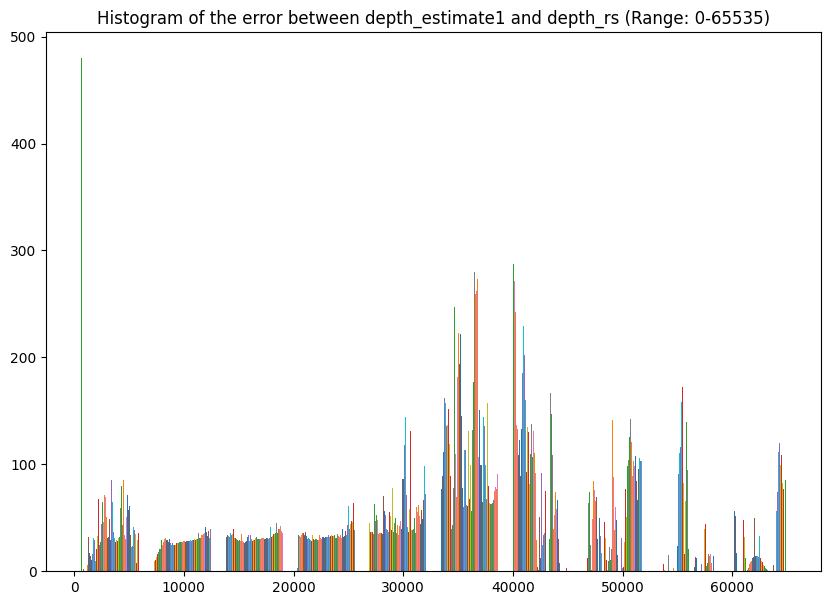

In [37]:
# frame 1: estimate
# frame 2: closest measurement
for frame1_idx in [297]: # TODO: later we look at all the frames
    frame2_idx = eval_utils.get_closest_index(frame1_idx, timestamps_cam1, timestamps_camdepth)
    
    eval_utils.create_parallel_plots(frame1_idx, frame2_idx, cam1depthestimate_key, camdepth_key, data_filename, test_run, model_type)
    eval_utils.create_differencing_plot(frame1_idx, frame2_idx, data, cam1depthestimate_key, camdepth_key, test_run, model_type)
    
    eval_utils.visualize_errors(frame1_idx, frame2_idx, data, cam1depthestimate_key, camdepth_key, test_run, model_type)


    text="Histogram of the error between "+str(cam1depthestimate_key)+" and "+ str(camdepth_key)
    pic1 = data[test_run][model_type][cam1depthestimate_key][frame1_idx]
    pic2 = data[test_run][model_type][camdepth_key][frame2_idx]
    values_to_neglect = [0]
    difference_picture = eval_utils.get_difference_picture(pic1,pic2,values_to_neglect)
    eval_utils.create_plot(difference_picture)
    eval_utils.plot_error_histogram(text, difference_picture, 10)

> ### Findings: 
>
> 1. *HIGH MAGNITUDE ERRORS*: Very <ins>small artifacts</ins> in various places without obvious pattern 
> 2. *MEDIUM MAGNITUDE ERRORS*: Larger areas of <ins>lower accuracy</ins> in the <ins>background</ins>
>    * might not be too relevant for decisions during flight
>    * especially present at the edges of objects
> 3. *LOW MAGNITUDE ERRORS*: Tendency of errors towards the <ins>foreground</ins>




---
# Work in progress beyond this point: 
---

###  Finding the indices where the ground truth is best comparable with the depth estimation, because they have been taken at a similar time.

In [38]:
def find_indices(array1, array2, threshold):
    indices = []
    for i in range(len(array1)):
        for j in range(len(array2)):
            if abs(array1[i] - array2[j]) <= threshold:
                indices.append((i, j))
    return indices


array1 = np.array(timestamps_cam1)
array2 = np.array(timestamps_cam2)
threshold = 0.0001

indices = find_indices(array1, array2, threshold)
print(indices)

[(8, 7), (32, 36), (570, 567), (615, 611), (798, 795)]
